In [1]:
%matplotlib inline

In [27]:
from __future__ import division, print_function, absolute_import
import sys
sys.path.append('MO-ASMO/src/')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import os
import pickle
import re
import random
import gp

This notebook is a based on https://github.com/NCAR/ctsm_optz/blob/main/additional_parameter_filter.ipynb

# Read CLM runoff sensitivities

Steps performed before :
1. Latin Hypercube (LHS) sampling (N=200 parameter sets) of 37 parameters selected parameters based on Parameter Perturbed Experiment (PPE). Check steps 1 and 2 from https://github.com/NCAR/ctsm_optz for LHS sampling and parameter screening from PPE output.

2. CLM is run with each parameter set for 1950-2010 (first 2-years for spinup).

3. For each run, calculate runoff sensitivities (see notebook 1_LHS_parameters_runoff_sensitivities). 

In [19]:
# Path to model simulations of runoff sensitivities
wfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/screening_lhs/pe_basin_0_metrics.pkl'
dict_metrics = pickle.load( open( wfile, "rb" ) )

In [20]:
# Calculate evaluation metric:
avmetric = (dict_metrics['yampa']['alpha'] + dict_metrics['animas']['alpha'] + dict_metrics['east']['alpha'])/3
# avmetric = (dict_metrics['yampa']['beta'] + dict_metrics['animas']['beta'] + dict_metrics['east']['beta'])/3

In [21]:
evaluate_metric=['alpha']
nOutput = len(evaluate_metric)

metric_baseline_mean_norm = pd.DataFrame([avmetric.iloc[-1]],index=evaluate_metric, columns=['baseline'])
metric_baseline_mean_norm

evaluate_metric=metric_baseline_mean_norm.index.values
nOutput = len(evaluate_metric)

metric_mean = avmetric.iloc[:-1]
norm_metric_mean = pd.DataFrame([metric_mean.values],index=evaluate_metric,columns=metric_mean.index)

# Read CLM parameter values

In [12]:
# 
init_iteration = 0
# define the number of parameters in each updated run
N_resample = 1
location = 'pe_basin'
sheetname = 'T10'
num_init_sampling = 200

# define hyper parameters
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20

# Paths are obtained from reference CLM case using development tag: branch_tags/PPE.n12_ctsm5.1.dev030
basepftfile = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc' 
namelist_file = '/glade/work/elkoukah/cases/I2000_PPEn12CTSM51_ucrb-yampa_singlept.base/CaseDocs/lnd_in'

In [13]:
param_df = pd.DataFrame([])
job_id_list = np.array([])

# Path to Latin Hypercube sample of parameter values
source_dir = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/screening_lhs/'

for iter_ in range(0, init_iteration+1):
    if iter_ == 0:
        job_id_file = source_dir + 'pe_basin_%s.main_run.txt'%(iter_)
        param_pertubed_file = source_dir + 'pe_basin_%s.param_list.txt'%(iter_)

    # read the file
    param_df_temp = pd.read_csv(param_pertubed_file,index_col=[0])
    job_id_df = pd.read_csv(job_id_file,header=None)
    job_id_list_temp = job_id_df[0].values
    
    if iter_ == 0:
        num_init_jobs = len(job_id_list_temp)
    # concat parameter file and job id list
    param_df = pd.concat([param_df,param_df_temp])
    job_id_list = np.concatenate([job_id_list, job_id_list_temp])

num_param = param_df.shape[1]

In [14]:
param_df_all = pd.read_csv('/glade/work/elkoukah/empirical/tools/ppe_tools/analysis/p.csv')
df_param_sel_sort = pd.read_csv('/glade/work/elkoukah/inputs/params/params_ppe11_selected_not_normalized_corrected.csv', index_col=0)

param_names = df_param_sel_sort.index.values

rows_list = []
for row in param_df_all.iterrows():
    if row[1]['name'] in param_names:
        rows_list.append(param_df_all.iloc[row[0]])

pf = pd.DataFrame(rows_list)

nInput = len(pf)
nOutput = len(evaluate_metric)
file_location = pf['location'].values
N_var_list = pf[pf['location']=='N']['name'].values
P_var_list = pf[pf['location']=='P']['name'].values

# get the upper and lower bound of the parameter files
f = open(namelist_file, "r")
namelist_f = pd.DataFrame([],columns=['value'])
for x in f:
    string_list = x.split(sep='=')
    st_list = []
    for st in string_list:
        st_list.append(st.strip())
    if len(st_list) == 2:
        df = pd.DataFrame([st_list[1]],columns=['value'],index=[st_list[0]])
        namelist_f = pd.concat([namelist_f,df],axis=0)
        
# read in parameter files
param_ds = xr.open_dataset(basepftfile)

var_min='min'
var_max='max'
var_pft_min = 'pft_mins'
var_pft_max = 'pft_maxs'
var_param = 'name'
pf[var_min] = pf[var_min].astype(str)
pf[var_max] = pf[var_max].astype(str)
pft_type_sel = np.arange(79)#np.array([2,11,12]).astype(np.int32)

In [ ]:
vmin_list = []
vmax_list = []
v_default_list = []
for row in pf.iterrows():
    param_name = row[1][var_param]
    if row[1]['location'] == 'N':
        default_value = namelist_f.loc[param_name]['value']
        if type(default_value) is str:
            default_value = float(default_value.split('d')[0])
        print(param_name,default_value)
        v_default_list.append(default_value)
        if 'percent' in row[1][var_min]:
            pct_min = float(row[1][var_min].split('percent')[0])
            pct_max = float(row[1][var_max].split('percent')[0])
            vmin_list.append(default_value*(1-pct_min/100))
            vmax_list.append(default_value*(1+pct_max/100))
        else:
            vmin_list.append(float(row[1][var_min]))
            vmax_list.append(float(row[1][var_max]))
    else:
        if row[1]['location'] == 'P':
            default_value = param_ds[param_name].values
            v_default_list.append(default_value)
            if 'percent' in row[1][var_min]:
                pct_min = float(row[1][var_min].split('percent')[0])
                pct_max = float(row[1][var_max].split('percent')[0])
                vmin_list.append(default_value*(1-pct_min/100))
                vmax_list.append(default_value*(1+pct_max/100))
            else:
                if row[1][var_min] == 'pft':
                    pft_mins = row[1][var_pft_min]
                    pft_maxs = row[1][var_pft_max]
                    pft_mins = np.array(pft_mins.split(',')).astype(np.float64)
                    pft_maxs = np.array(pft_maxs.split(',')).astype(np.float64)
                    vmin_list.append(pft_mins[pft_type_sel])
                    vmax_list.append(pft_maxs[pft_type_sel])
#                     print(pft_mins[pft_type_sel], pft_maxs[pft_type_sel])
                else:
                    if type(default_value) == np.ndarray:
                        vmin_list.append(np.full(default_value.shape,float(row[1][var_min])))
                        vmax_list.append(np.full(default_value.shape,float(row[1][var_max])))
                    else:
                        vmin_list.append(float(row[1][var_min]))
                        vmax_list.append(float(row[1][var_max]))
pf['vmin_value'] = vmin_list
pf['vmax_value'] = vmax_list
pf['v_default'] = v_default_list

xlb = pf['vmin_value'].values
xub = pf['vmax_value'].values
x_default = pf['v_default'].values

In [18]:
xlb_single_value = []
xub_single_value = []
x_default_value = []

for i_param,param in enumerate(pf[var_param].values):
    lb = xlb[i_param]
    ub = xub[i_param]
    default = x_default[i_param]
    if type(lb) is not np.float64:
        xlb_single_value.append(np.mean(lb))
        xub_single_value.append(np.mean(ub))
        x_default_value.append(np.mean(default))
    else:
        xlb_single_value.append(lb)
        xub_single_value.append(ub)
        x_default_value.append(default)
        
xub_single_value = np.array(xub_single_value).astype(np.float64)
xlb_single_value = np.array(xlb_single_value).astype(np.float64)
x_default_single_value = np.array(x_default_value).astype(np.float64)

param_train_df = param_df.copy()

index_list = param_df.index.values
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *\-?\+?\ *[0-9]+)?')

for var in param_df.columns.values:
    if type(param_df.loc[index_list[0],var]) == str:
        v_list = []
        for index in index_list:
            my_list = [float(x) for x in re.findall(match_number, param_df.loc[index,var])]
            v_list.append(np.mean(my_list))
        param_train_df[var] = v_list

# Training a surrogate on CLM sensitivities and parameter values 

In [23]:
# calculate normalization scalar
param_init_df = param_train_df.iloc[0:num_init_sampling]
d = preprocessing.normalize(param_init_df,axis=0,return_norm=True)
normalization_scalar = d[1]

scaled_df = param_train_df/normalization_scalar

xlb_single_value_scaled = xlb_single_value/normalization_scalar
xub_single_value_scaled = xub_single_value/normalization_scalar

bound_df = pd.DataFrame(np.transpose([xlb_single_value,xub_single_value,x_default_single_value]),index=param_df.columns.values,columns=['lb','ub','default'])
bound_scale_df = bound_df.divide(normalization_scalar,axis=0)

available_id_list = norm_metric_mean.columns.values

# start training the surrogate models
x = scaled_df.loc[available_id_list].values
y = norm_metric_mean.loc[evaluate_metric].T.values

## Surrogate cross-validation

2.5 0 (160, 37)
2.5 1 (160, 37)
2.5 2 (160, 37)
2.5 3 (160, 37)
2.5 4 (160, 37)
2.5 0.016335746884759778 (160, 37)


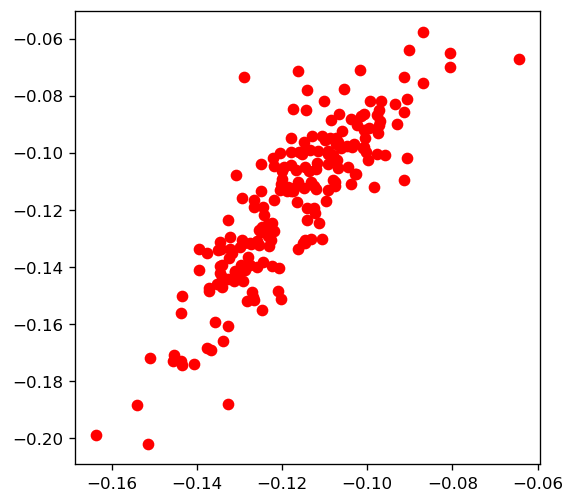

In [28]:
k_fold = 5
tot_sample_size = norm_metric_mean.shape[1]
num_validate_per_k = tot_sample_size/k_fold
num_train_per_k = tot_sample_size - num_validate_per_k

tot_id_list = np.arange(tot_sample_size)

# shuffle the id list
random.shuffle(tot_id_list)

alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

plt.figure(figsize=[5,5],dpi=120)
for alpha in [alpha]:
    rmse_list = []
    for k in range(k_fold):
        validate_id_list = tot_id_list[int(k*num_validate_per_k):int((k+1)*num_validate_per_k)]
        train_id_list = np.array(list(set(tot_id_list).difference(validate_id_list)))

        x_train = x[train_id_list, :]
        x_val = x[validate_id_list, :]

        y_train = y[train_id_list, :]
        y_val = y[validate_id_list, :]

        sm_test = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub],nu=nu)
        y_predict = sm_test.predict(x_val)

        rmse_list.append(np.sqrt(pow(y_predict - y_val, 2).mean()))
        print(nu, k, x_train.shape)
        plt.scatter(y_predict.T[0],y_val.T[0],color='r')
        if nOutput == 2:
            plt.scatter(y_predict.T[1],y_val.T[1],color='b')
    print(nu, np.mean(rmse_list), x_train.shape)

- x is the simulated precipitation sensitivity ($\alpha$) by CLM. y is predicted $\alpha$ by the surrogate model
- Mean Root mean square error = 0.016

## Convergence of surrogate-estimated parameter sensitivity

In [31]:
sens_arr = np.full((37, 10), np.nan)

for fii in range(1,11):
    idxs = np.random.choice(200, 20*fii, replace=False)
    idxs = np.sort(idxs)
    # calculate normalization scalar
    param_init_df = param_train_df.iloc[idxs]
    d = preprocessing.normalize(param_init_df,axis=0,return_norm=True)
    normalization_scalar = d[1]

    scaled_df = param_train_df.iloc[idxs]/normalization_scalar

    xlb_single_value_scaled = xlb_single_value/normalization_scalar
    xub_single_value_scaled = xub_single_value/normalization_scalar

    bound_df = pd.DataFrame(np.transpose([xlb_single_value,xub_single_value,x_default_single_value]),index=param_df.columns.values,columns=['lb','ub','default'])
    bound_scale_df = bound_df.divide(normalization_scalar,axis=0)
    
    # start training the surrogate models
    x = scaled_df.values
    y = norm_metric_mean.iloc[:, idxs].T.values

    alpha = 1e-3
    lb = 1e-3
    ub = 1e3
    nu = 2.5
    sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], 
                       xlb_single_value_scaled, 
                       xub_single_value_scaled,
                       alpha=alpha, leng_sb=[lb,ub], 
                       nu=nu)
    
    df_range_sum = pd.DataFrame()
    for i_param,param in enumerate(bound_scale_df.index.values):
        y_sim = []
        lb = bound_scale_df['lb'].loc[param]
        ub = bound_scale_df['ub'].loc[param]
        x_sim_list = []
        for j in range(11):
            x_sim = lb + (ub-lb)*j/10
            x_sim_list.append(x_sim)
        for ii in range(20*fii):
            x_ii = x[ii]
            xinput = np.stack([x_ii]*11)
            xinput[:, i_param] = x_sim_list
            y_sim.append(sm.predict(xinput))
        y_sim_mean = np.mean(np.stack(y_sim),axis=0)
        y_sim_df = pd.DataFrame(y_sim_mean,columns=evaluate_metric)
        df_range = pd.DataFrame(y_sim_df.max(axis=0) - y_sim_df.min(axis=0), columns=[param])
        df_range_sum = pd.concat([df_range_sum,df_range],axis=1)
    
    df_range_sum = df_range_sum.T
    df_range_sum['sum'] = df_range_sum[evaluate_metric[0]]
    df_range_sorted = df_range_sum.sort_values('sum',ascending = False)
    sens_arr[:, fii-1] = df_range_sum.iloc[:, 0].values
    print(fii)

1
2
3
4
5
6
7
8
9
10


### Figure

In [32]:
sens_arr_alpha = sens_arr.copy()

In [33]:
# Before running this, replace alpha with beta (in Calculate evaluation metric) in the first section and rerun all cells (except the one above).
sens_arr_beta = sens_arr.copy()

In [34]:
selected_params = ['medlynintercept', 'fff', 'frac_sat_soil_dsl_init', 'watsat_sf', 'd_max']
selected_params_idx = [27,17,4,11,3]

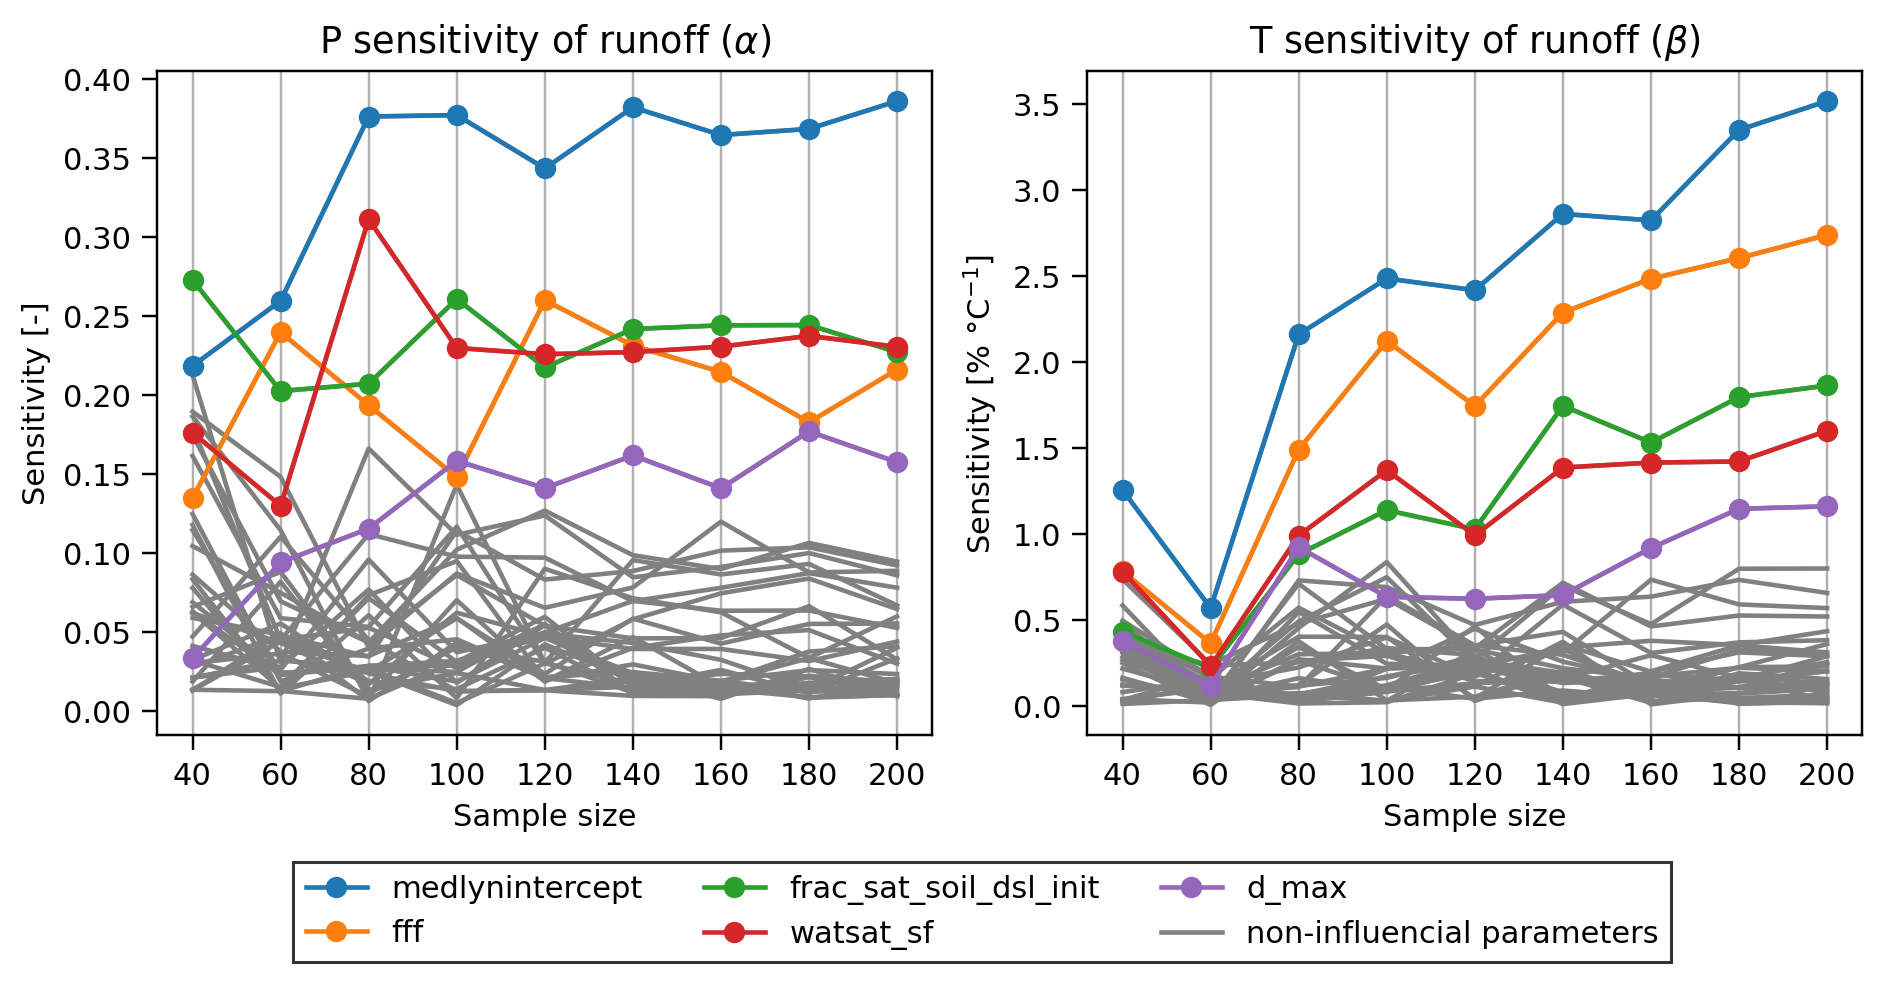

In [94]:
fig, axes = plt.subplots(1,2,figsize=[10,4],dpi=220)
ax2, ax1 = axes
ii = 1
lp = ax1.plot(sens_arr_beta.T[ii:, :]*100, color='grey');
ax1.plot(sens_arr_beta.T[ii:, selected_params_idx]*100, marker='o', label=selected_params);
ax1.set_xticks(np.arange(10)[:ii*-1], np.arange(20,201,20)[ii:])
ax1.set_xlabel('Sample size')
ax1.set_ylabel('Sensitivity [% $\degree$C$^{-1}$]')
ax1.set_title(r'T sensitivity of runoff ($\beta$)')

ax2.plot(sens_arr_alpha.T[ii:, :], color='grey');
sc = ax2.plot(sens_arr_alpha.T[ii:, selected_params_idx], marker='o', label=selected_params);
ax2.set_xticks(np.arange(10)[:ii*-1], np.arange(20,201,20)[ii:])

ax2.set_xlabel('Sample size')
ax2.set_ylabel('Sensitivity [-]')
ax2.set_title(r'P sensitivity of runoff ($\alpha$)')
ax1.tick_params(length=5)
ax2.tick_params(length=5)

ax1.grid(axis='x')
ax2.grid(axis='x')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles+[lp[0]], labels+['non-influencial parameters'], frameon=True, fancybox=False, ncol=3, bbox_to_anchor=(0.5,-0.15), edgecolor='k', loc='lower center')
